In [1]:
# set up
import sys, os
import numpy as np
import random
import matplotlib.pyplot as plot
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

(180,)
0.0


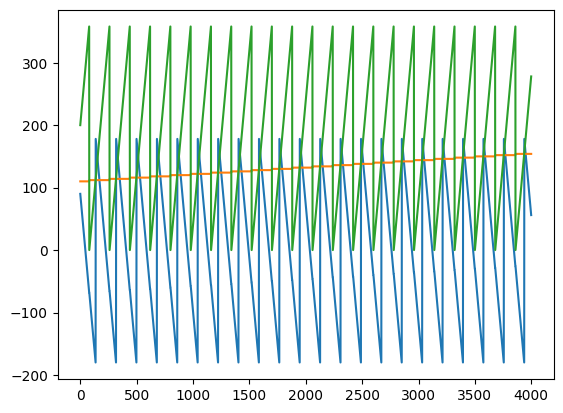

In [14]:
# simulate sampling HD and body position in a circle
bsa = np.empty(shape=[1])
hd = np.empty(shape=[1])
HD_range = np.arange(0,360,2)
print(np.shape(HD_range))
# bsa_range = np.arange(0,360,2) # if shelter is in the middle
bsa_range = np.arange(0,180,2) # if shelter is on the edge
for i in bsa_range:
    hd = np.append(hd,HD_range)
    bsa = np.append(bsa,np.ones(shape=[len(HD_range),1])*i)
hd = hd[1:]
bsa = bsa[1:]

# add HD to (180-shelter angle)
hsa = hd + (180-bsa)
hsa[hsa>180] = (hsa[hsa>180] - 360)*-1
hsa = np.absolute(hsa)

# make it from -180 to +180 for turning different ways
zero_angle = np.empty(shape = np.shape(hsa))
zero_angle[bsa<180] = bsa[bsa<180]+180
zero_angle[bsa>=180] = bsa[bsa>=180]-180
idx = np.logical_and(np.logical_or(hd > zero_angle,hd < bsa),bsa<180)
hsa[idx] = hsa[idx]*-1
idx = np.logical_and(np.logical_and(hd > zero_angle,hd < bsa),bsa>=180)
hsa[idx] = hsa[idx]*-1

hsa[hsa == 180] = -180


In [3]:
# the values after the hashtag are the ones from the HD data of ADn neurons (run JR_CellSimulate)
# extract the mean and std of tuning curve amplitude
mean_amp = 30 # 30
std_amp = 38 # 38

# extract mean and std of tuning curve width
mean_width = 37 # 37
std_width = 15 # 35

# extract mean and std of std in response vs. angles
mean_amp_std = 14 # 14
std_amp_std = 13 # 13
mean_std = 71 # 71
std_std = 30 # 64

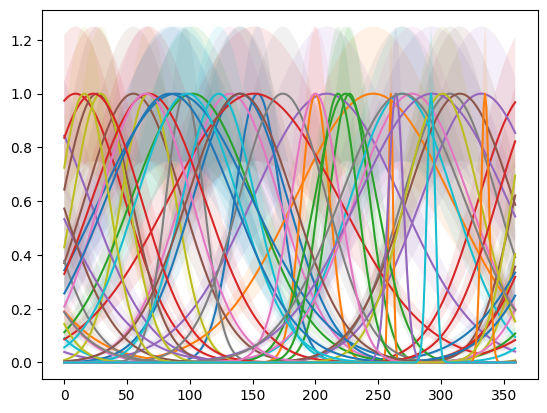

In [19]:
# make the HSA and HD cell firing rate using HD cell tuning
hdcellnum = 20
hsacellnum = 20
cellnum = hdcellnum + hsacellnum
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
sim_tuning_resp = np.empty(shape=[cellnum,360])
sim_tuning_std = np.empty(shape=[cellnum,360])
for c in np.arange(cellnum): # iterate over cells (half are going to be HD, half HSA)
    pref_dir = np.random.uniform(0, 360)
    shift = np.round(180 - pref_dir)
    x_gaus = np.arange(360)
    this_amp = np.absolute(np.random.normal(mean_amp,std_amp))
    this_std_amp = np.absolute(np.random.normal(mean_amp_std,std_amp_std))
    # if you want all responses normalized
    this_amp = 1
    this_std_amp = .25
    # for each cell make a gaussian of firing vs. angles
    this_std = np.random.normal(mean_width,std_width)
    sim_tuning_resp[c,:] = gaus(x_gaus,this_amp,180,this_std)
    sim_tuning_resp[c,:] = np.roll(sim_tuning_resp[c,:],shift.astype(int))
    # for each cell make a gaussian of std in firing rate vs. angles
    # this_std = np.random.normal(mean_std,std_std)
    sim_tuning_std[c,:] = gaus(x_gaus,this_std_amp,180,this_std)
    sim_tuning_std[c,:] = np.roll(sim_tuning_std[c,:],shift.astype(int))
    plot.plot(x_gaus,sim_tuning_resp[c,:])
    plot.fill_between(x_gaus, sim_tuning_resp[c,:]-sim_tuning_std[c,:], sim_tuning_resp[c,:]+sim_tuning_std[c,:],alpha=0.1)
plot.show()

# look at them
# plot.imshow(sim_tuning_resp,aspect=10,cmap = 'Greys')
# plot.show()
# plot.imshow(sim_tuning_std,aspect=10,cmap = 'Greys')
# plot.show()

# look at one
# c=15
# plot.plot(x_gaus,sim_tuning_resp[c,:])
# plot.fill_between(x_gaus, sim_tuning_resp[c,:]-sim_tuning_std[c,:], sim_tuning_resp[c,:]+sim_tuning_std[c,:],alpha=0.1)
# plot.plot(x_gaus,sim_tuning_std[c,:])

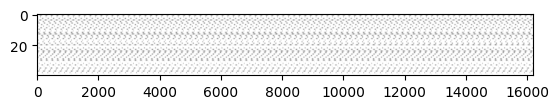

In [20]:
# firing rate over time
hsa_round = np.round(hsa) # if using simulated HD and pos
hd_round = np.round(hd) # if using simulated HD and pos
sim_rate = np.empty(shape=[cellnum,len(hsa_round)])
for c in np.arange(cellnum): # iterate over cells
    for a in np.arange(360): # iterate over angles
        if c < hdcellnum: # HD cells
            these_times = np.where(hd_round == a)[0]
        else:
            these_times = np.where(hsa_round == a-180)[0]
        sim_val = np.random.normal(sim_tuning_resp[c,a], sim_tuning_std[c,a], size=len(these_times))
        sim_rate[c,these_times] = sim_val
    sim_rate[c,sim_rate[c,:]<0] = 0
del sim_val, these_times
plot.imshow(sim_rate,aspect=50,cmap = 'Greys',vmax = np.amax(sim_rate))
plot.show()
del sim_tuning_resp, sim_tuning_std, 